# Quantium Virtual Internship - Retail Strategy and Analytics 

<b>Background information for this task</b>

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88. Consider match trial stores to control stores that are similar to the trial store prior to the trial period of Mar 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers

The trial period goes from the start of March 2019 to June 2019. The task is to test if total sales are significantly different in the trial period.

<b>Main areas of Focus are</b>

- Calculate similarity based on matrics
- Select control stores 
- Assessment of the trial 
- Draw conclusion

## Table of content<a class = "anchor" id ="table"></a>

* [1. Load required libraries and data preparation](#1)
* [2. Create functions for calculating similarity](#2)
* [3. Trail store 77](#3)
* [3.1. Similarity calculation](#3.1)
* [3.2. Get the control store and vistual the trends](#3.2)
* [3.3. Assessment of trial](#3.3)
* [3.3.1. Scale pre-trial control sales to pre-trial trail sales](#3.3.1)
* [3.3.2. Calculate percentage difference between scaled sales and true sales ](#3.3.2)
* [3.3.3. Measure whether difference on sales is significant](#3.3.3)
* [3.3.4. Scale pre-trial control ncustomer to pre-trial trail ncustomer](#3.3.4)
* [3.3.5. Calculate percentage difference between scaled nCustomers and true nCustomers ](#3.3.5)
* [3.3.6. Measure whether difference on ncustomer is significant](#3.3.6)
* [4. Trail store 86](#4)
* [4.1. Similarity calculation](#4.1)
* [4.2. Get the control store and vistual the trends](#4.2)
* [4.3. Assessment of trial](#4.3)
* [4.3.1. Scale pre-trial control sales to pre-trial trail sales](#4.3.1)
* [4.3.2. Calculate percentage difference between scaled sales and true sales ](#4.3.2)
* [4.3.3. Measure whether difference on sales is significant](#4.3.3)
* [4.3.4. Scale pre-trial control ncustomer to pre-trial trail ncustomer](#4.3.4)
* [4.3.5. Calculate percentage difference between scaled nCustomers and true nCustomers ](#4.3.5)
* [4.3.6. Measure whether difference on ncustomer is significant](#4.3.6)
* [5. Trial store 88](#5)
* [5.1. Similarity calculation](#5.1)
* [5.2. Get the control store and vistual the trends](#5.2)
* [5.3. Assessment of trial](#5.3)
* [5.3.1. Scale pre-trial control sales to pre-trial trail sales](#5.3.1)
* [5.3.2. Calculate percentage difference between scaled sales and true sales ](#5.3.2)
* [5.3.3. Measure whether difference on sales is significant](#5.3.3)
* [5.3.4. Scale pre-trial control ncustomer to pre-trial trail ncustomer](#5.3.4)
* [5.3.5. Calculate percentage difference between scaled nCustomers and true nCustomers ](#5.3.5)
* [5.3.6. Measure whether difference on ncustomer is significant](#5.3.6)
* [6. Conclusion](#6)

## 1. Load required libraries and data preparation<a class="anchor" id="1"></a>
[Back to top](#table)

In [1]:
library(data.table)
library(ggplot2)
library(tidyr)

In [2]:
filePath <- getwd()
data <- fread(paste0(filePath,"/QVI_data.csv"))
head(data)

LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
<int>,<date>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
1005,2018-12-28,1,6,86,Cheetos Puffs 165g,1,2.8,165,CHEETOS,MIDAGE SINGLES/COUPLES,Mainstream


Since the store similarity is calculated by some monthly measurement, we need to group the records by month and summarise them by store and month.

In [3]:
#### Create a month ID
data[, YEARMONTH := year(DATE)*100 + month(DATE)]
#### Define the measure calculations
measureOverTime <-  data[, .(totSales = sum(TOT_SALES),
                            nCustomers = uniqueN(LYLTY_CARD_NBR),
                            nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
                            nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID)),
                        ,by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]
head(measureOverTime)

STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,201807,206.9,49,1.061224,1.192308
1,201808,176.1,42,1.023810,1.255814
1,201809,278.8,59,1.050847,1.209677
1,201810,188.1,44,1.022727,1.288889
1,201811,192.6,46,1.021739,1.212766
1,201812,189.6,42,1.119048,1.212766


We need the dataset with pre-trail records. As mentioned, the trail was started on Feb, 2019.

In [4]:
#### Filter to the pre‐trial period and stores with full observation periods
storesWithFullObs <- unique(measureOverTime[, .N, STORE_NBR][N == 12, STORE_NBR])
preTrialMeasures <- measureOverTime[YEARMONTH < 201903 & STORE_NBR %in% storesWithFullObs, ]

## 2. Create functions for calculating similarity<a class="anchor" id="2"></a>
[Back to top](#table)

<b>similarity matric</b>
- monthly sales
- monthly customers 

<b>similarity score</b> = 0.5 * <b>correlation</b> + 0.5 * <b>magnitude distance</b>  

In [5]:
#### Create a function to calculate correlation for a measure
calculateCorrelation <- function(inputTable, metricCol, storeComparison){
    #### build a new table
    calcCorrTable = data.table(Store1 = numeric(), 
                               Store2 = numeric(),
                               corr_measure = numeric())
    storeNumbers <- unique(inputTable[, STORE_NBR])
    #### loop through each control store
    for(i in storeNumbers){
        calculatedMeasure = data.table("Store1" = storeComparison,
                                       "Store2" = i,
                                       "corr_measure" = cor(inputTable[STORE_NBR == storeComparison, eval(metricCol)],
                                                           inputTable[STORE_NBR == i, eval(metricCol)])
                                      )
        #### keep appending records to the table
        calcCorrTable <- rbind(calcCorrTable, calculatedMeasure)    
    }
    return (calcCorrTable)
}

magnitude distance = 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance)

In [6]:
#### Create a function to calculate a standardised magnitude distance for a measure
calculateMagnitudeDistance <-  function(inputTable, metricCol, storeComparison){
    #### build a new table
    calcDistTable = data.table(Store1 = numeric(), 
                               Store2 = numeric(), 
                               YEARMONTH = numeric(), 
                               measure = numeric())
    storeNumbers <- unique(inputTable[, STORE_NBR])
    #### loop through each control store
    for (i in storeNumbers){
        calculatedMeasure = data.table("Store1" = storeComparison,
                                       "Store2" = i,
                                       "YEARMONTH" = inputTable[STORE_NBR == storeComparison, YEARMONTH],
                                       "measure" = abs(inputTable[STORE_NBR == storeComparison, eval(metricCol)] - 
                                                       inputTable[STORE_NBR == i, eval(metricCol)])
                                       )
        #### keep appending records to the table
        calcDistTable <- rbind(calcDistTable, calculatedMeasure)
    }
    #### standardise the magnitude distance
    minMaxDist <- calcDistTable[, .(minDist = min(measure), 
                                    maxDist = max(measure)),
                                by = c('Store1', 'YEARMONTH')]
    distTable <-  merge(calcDistTable, minMaxDist, by = c('Store1', 'YEARMONTH'))
    distTable[, magnitudeMeasure := 1-(measure - minDist)/(maxDist - minDist)]
    finalDistTable <- distTable[, .(mag_measure = mean(magnitudeMeasure)), by = .(Store1, Store2)]
    return (finalDistTable)
}

## 3. Trail store 77<a class="anchor" id="3"></a>
### 3.1. Similarity calculation <a class='anchor' id='3.1'></a>
[Back to top](#table)

In [7]:
trial_store <- 77
#### Use the functions for calculating correlation
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)
head(corr_nSales)
#head(corr_nCustomers)

Store1,Store2,corr_measure
<dbl>,<dbl>,<dbl>
77,1,0.05016309
77,2,-0.20079609
77,3,0.61657355
77,4,-0.09412536
77,5,-0.04576545
77,6,0.04852478


In [8]:
#### Use the functions for calculating magnitude
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)
head(magnitude_nSales)
#head(magnitude_nCustomers)

Store1,Store2,mag_measure
<dbl>,<dbl>,<dbl>
77,1,0.9580984
77,2,0.9351664
77,3,0.3321554
77,4,0.2107080
77,5,0.5563399
77,6,0.9719554


In [9]:
#### Create a combined score: 0.5 * correlation + 0.5 * magnitude
corr_weight <- 0.5
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))[
    , scoreNSales := corr_weight * corr_measure + (1-corr_weight) * mag_measure]
score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[
    , scoreNCust := corr_weight * corr_measure + (1-corr_weight) * mag_measure]
head(score_nSales)
#head(score_nCustomers)

Store1,Store2,corr_measure,mag_measure,scoreNSales
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,1,0.05016309,0.9580984,0.50413076
77,2,-0.20079609,0.9351664,0.36718515
77,3,0.61657355,0.3321554,0.47436449
77,4,-0.09412536,0.2107080,0.05829134
77,5,-0.04576545,0.5563399,0.25528724
77,6,0.04852478,0.9719554,0.51024010


In [10]:
#### Create a combined score: 0.5 * sales score + 0.5 * customers score
score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]
head(score_Control)

Store1,Store2,corr_measure.x,mag_measure.x,scoreNSales,corr_measure.y,mag_measure.y,scoreNCust,finalControlScore
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,1,0.05016309,0.9580984,0.50413076,0.3505720,0.9369781,0.64377505,0.573952906
77,2,-0.20079609,0.9351664,0.36718515,-0.4552264,0.9093669,0.22707022,0.297127687
77,3,0.61657355,0.3321554,0.47436449,0.7569126,0.3173654,0.53713901,0.505751750
77,4,-0.09412536,0.2107080,0.05829134,-0.3020461,0.2198937,-0.04107622,0.008607558
77,5,-0.04576545,0.5563399,0.25528724,0.2776192,0.4812343,0.37942676,0.317356996
77,6,0.04852478,0.9719554,0.51024010,0.1021348,0.9394511,0.52079298,0.515516541


### 3.2. Get the control store and vistual the trends <a class='anchor' id='3.2'></a>
[back on top](#table)

In [11]:
#### Select control stores based on the highest matching store
#### but not the store itself, so rank 2
control_store <- score_Control[Store1 == trial_store,][order(-finalControlScore)][2, Store2]
control_store

[1] 233

In [12]:
#### Set themes for plots
theme_set(theme_bw())
theme_update(plot.title = element_text(hjust = 0.5))

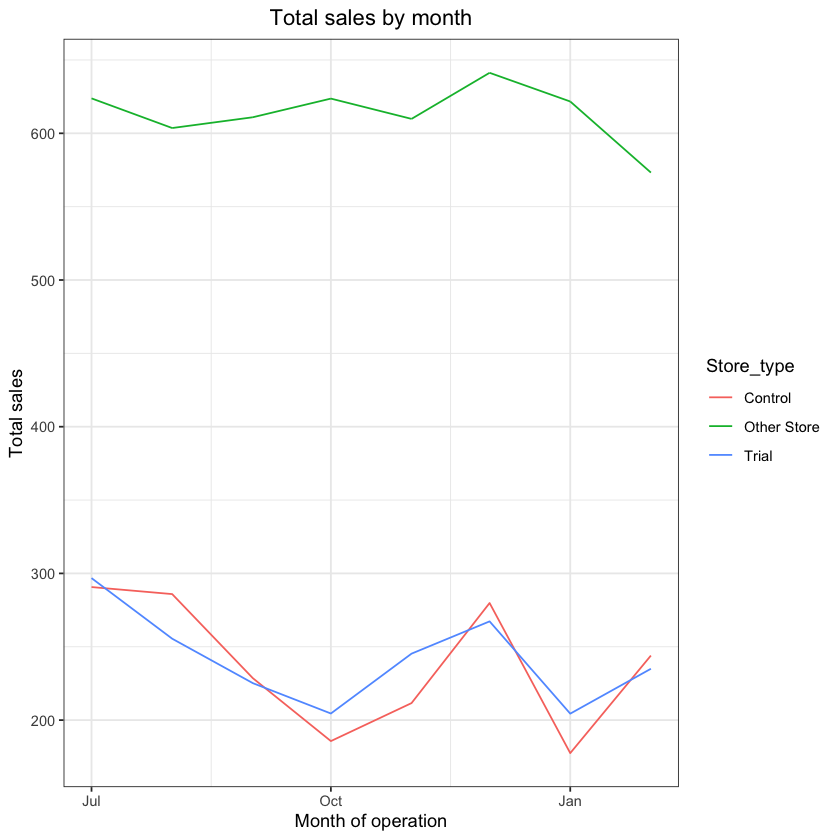

In [13]:
#### Visual checks on trends based on driver sales
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[
    , Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                           ifelse(STORE_NBR == control_store, "Control", 
                                  "Other Store"))][
    , totSales := mean(totSales), by = c("YEARMONTH", "Store_type")][
    , TransactionMonth := as.Date(paste(YEARMONTH %/%100, YEARMONTH %% 100, 1, sep='-'), '%Y-%m-%d')][
    YEARMONTH < 201903]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type))+
    geom_line()+
    labs(x="Month of operation", y = "Total sales", title = "Total sales by month")

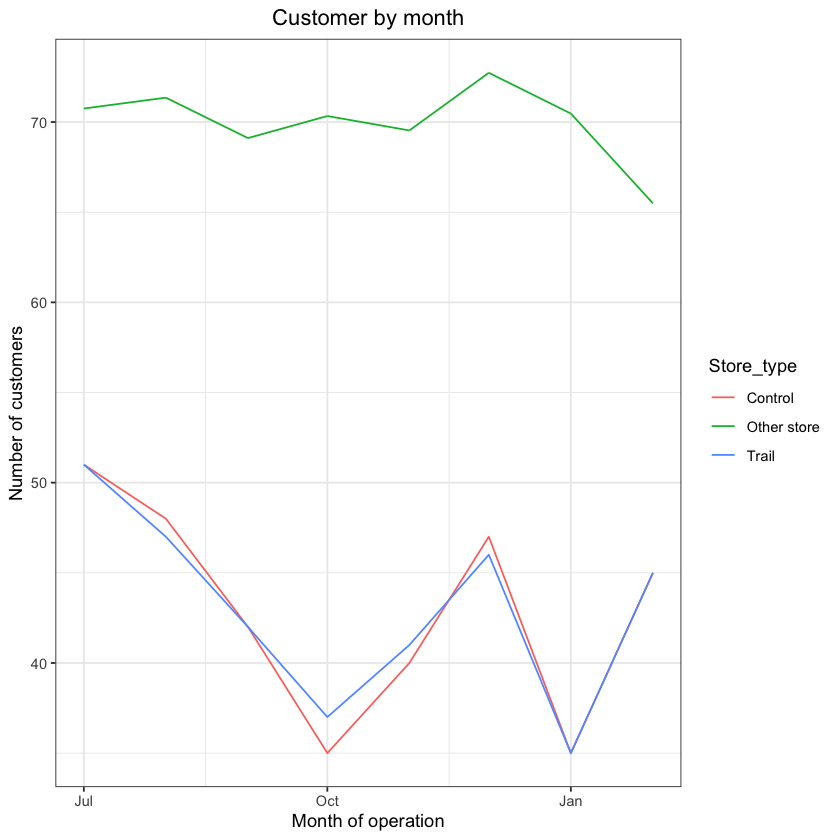

In [14]:
#### Visual checks on trends based on driver number of customers
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[
    , Store_type := ifelse(STORE_NBR == trial_store, "Trail",
                           ifelse(STORE_NBR == control_store, "Control", 
                                  "Other store"))][
    , numberCustomer := mean(nCustomers), by= c("YEARMONTH", "Store_type")][
    , TransactionMonth := as.Date(paste(YEARMONTH %/%100, YEARMONTH %% 100, 1, sep='-'), '%Y-%m-%d')][
    YEARMONTH < 201903, ]
ggplot(pastCustomers, aes(TransactionMonth, numberCustomer, color = Store_type)) +
    geom_line() +
    labs(x = "Month of operation", y = "Number of customers", title = "Customer by month")

We now want to see if there has been an uplift in overall chip sales.

### 3.3. Assessment of trial <a class='anchor' id='3.3'></a>
#### 3.3.1. Scale pre-trial control sales to pre-trial trail sales <a class='anchor' id='3.3.1'></a>
[back on top](#table)

In [15]:
#### Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales <- preTrialMeasures[
    STORE_NBR == trial_store & YEARMONTH < 201903, sum(totSales)]/preTrialMeasures[
    STORE_NBR == control_store & YEARMONTH < 201903, sum(totSales)]
scalingFactorForControlSales

[1] 1.015863

In [16]:
#### Apply the scaling factor
measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][ 
    ,controlSales := totSales * scalingFactorForControlSales]
head(scaledControlSales)

STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,Store_type,TransactionMonth,numberCustomer,controlSales
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>
233,201807,290.7,51,1.058824,1.629630,Control,2018-07-01,51,295.3114
233,201808,285.9,48,1.041667,1.600000,Control,2018-08-01,48,290.4352
233,201809,228.6,42,1.071429,1.555556,Control,2018-09-01,42,232.2263
233,201810,185.7,35,1.028571,1.555556,Control,2018-10-01,35,188.6458
233,201811,211.6,40,1.025000,1.512195,Control,2018-11-01,40,214.9566
233,201812,279.8,47,1.063830,1.500000,Control,2018-12-01,47,284.2385


#### 3.3.2. Calculate percentage difference between scaled sales and true sales <a class='anchor' id='3.3.2'></a>
[back on top](#table)

In [17]:
percentageDiff <- merge(
    scaledControlSales[, c('YEARMONTH', 'controlSales')],
    measureOverTime[STORE_NBR == trial_store, c('YEARMONTH', 'totSales')],
    by='YEARMONTH')[
    , percentageDiff := abs(controlSales - totSales)/controlSales,]
head(percentageDiff)

YEARMONTH,controlSales,totSales,percentageDiff
<dbl>,<dbl>,<dbl>,<dbl>
201807,295.3114,296.8,0.005040858
201808,290.4352,255.5,0.120285801
201809,232.2263,225.2,0.030256197
201810,188.6458,204.5,0.084042381
201811,214.9566,245.3,0.141160518
201812,284.2385,267.3,0.059592463


#### 3.3.3. Measure whether difference on sales is significant <a class='anchor' id='3.3.3'></a>
[back on top](#table)

<b>Null hypothesis</b>: Sales is no difference between trial period and pre-trial period.  
<b>Alternatives hypothesis</b>: There is difference.

In [18]:
#### take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev <- sd(percentageDiff[YEARMONTH < 201903 , percentageDiff])
#### There are 8 months in the pre-trial period, hence degree of freedom = 8-1 = 7
degreesOfFreedom <- 7
#### Test the null hypothesis
percentageDiff[, tValue := (percentageDiff - 0)/stdDev][
    , TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][
    YEARMONTH < 201907 & YEARMONTH > 201902, .(TransactionMonth, tValue)]
#### 95th percentile of the t distribution 
qt(0.95, df=degreesOfFreedom)

TransactionMonth,tValue
<date>,<dbl>
2019-03-01,7.534212
2019-04-01,12.701240
2019-05-01,2.888606
2019-06-01,3.578398


[1] 1.894579

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution - i.e. the increase in sales in the trial store is statistically greater than in the control store.

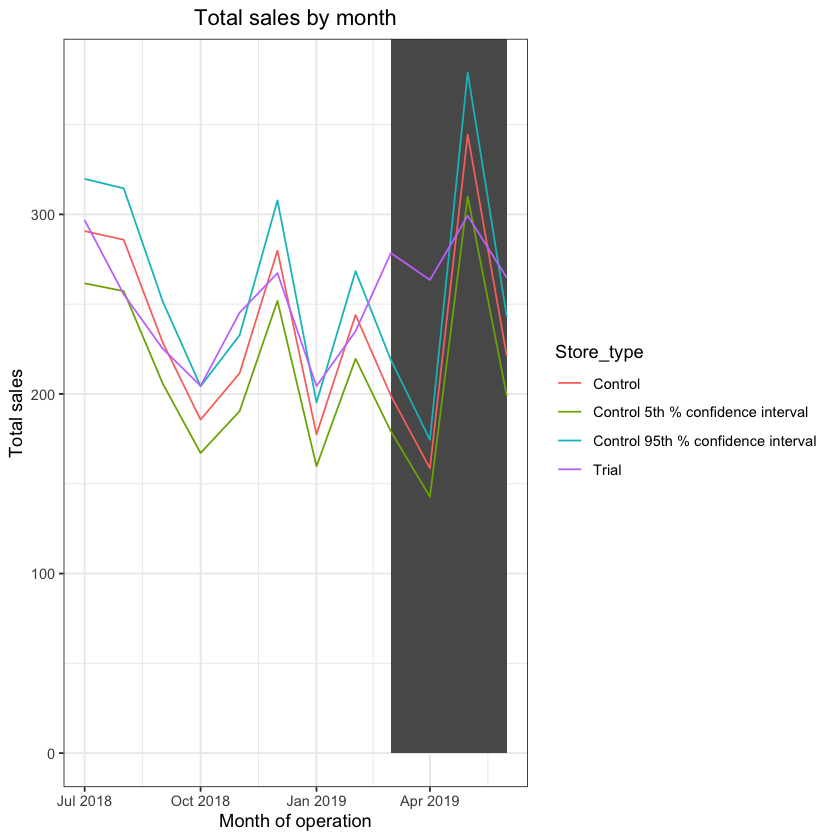

In [19]:
#### Create a visual version
measureOverTimeSales <- measureOverTime
#### Trial and control store total sales
pastSales <- measureOverTimeSales[
    , Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                           ifelse(STORE_NBR == control_store, "Control", 
                                  "Other stores"))][
    , totSales := mean(totSales), by = c("YEARMONTH", "Store_type")][
    , TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep="-"), "%Y-%m-%d")][
    Store_type %in% c("Trial", "Control"),]
#### Control store 95th percentile
pastSales_Controls95 <- pastSales[Store_type == "Control",][
    , totSales := totSales * (1 + stdDev * 2)][
    , Store_type := "Control 95th % confidence interval"]
#### Control store 5th percentile
pastSales_Controls5 <- pastSales[Store_type == "Control",][
    , totSales := totSales * (1 - stdDev * 2)][
    , Store_type := "Control 5th % confidence interval"]
trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)
#### Plotting these in one graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
    geom_rect(data = trialAssessment[ YEARMONTH < 201907 & YEARMONTH > 201902 ,],
              aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), 
                  ymin = 0 , ymax =Inf, color = NULL), show.legend = FALSE) +
    geom_line() +
    labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in three of the four trial months.

#### 3.3.4. Scale pre-trial control ncustomer to pre-trial trail ncustomer <a class='anchor' id='3.3.4'></a>
[back on top](#table)

In [20]:
#### Scale pre-trial control ncustomer to match pre-trial trial store ncustomer
scalingFactorForControlCust <- preTrialMeasures[
    STORE_NBR == trial_store & YEARMONTH < 201903,sum(nCustomers)]/preTrialMeasures[
    STORE_NBR == control_store & YEARMONTH < 201903, sum(nCustomers)]
scalingFactorForControlCust

[1] 1.002915

In [21]:
#### Apply the scaling factor
measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,][
    , controlCustomers := nCustomers * scalingFactorForControlCust]
head(scaledControlCustomers)

STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,Store_type,TransactionMonth,numberCustomer,controlCustomers
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>
233,201807,290.7,51,1.058824,1.629630,Control,2018-07-01,51,51.14869
233,201808,285.9,48,1.041667,1.600000,Control,2018-08-01,48,48.13994
233,201809,228.6,42,1.071429,1.555556,Control,2018-09-01,42,42.12245
233,201810,185.7,35,1.028571,1.555556,Control,2018-10-01,35,35.10204
233,201811,211.6,40,1.025000,1.512195,Control,2018-11-01,40,40.11662
233,201812,279.8,47,1.063830,1.500000,Control,2018-12-01,47,47.13703


#### 3.3.5. Calculate percentage difference between scaled ncustomers and true ncustomers <a class='anchor' id='3.3.5'></a>
[back on top](#table)

In [22]:
percentageDiff <- merge(scaledControlCustomers[,c("YEARMONTH", "controlCustomers")],
                        measureOverTime[STORE_NBR == trial_store, c("YEARMONTH", "nCustomers")],
                        by = "YEARMONTH")[
    , percentageDiff := abs(controlCustomers - nCustomers)/controlCustomers]
head(percentageDiff)

YEARMONTH,controlCustomers,nCustomers,percentageDiff
<dbl>,<dbl>,<int>,<dbl>
201807,51.14869,51,0.002906977
201808,48.13994,47,0.023679748
201809,42.12245,42,0.002906977
201810,35.10204,37,0.054069767
201811,40.11662,41,0.022020349
201812,47.13703,46,0.024121722


#### 3.3.6. Measure whether difference on ncustomer is significant <a class='anchor' id='3.3.6'></a>
[back on top](#table)

<b>Null hypothesis</b>: Number of customers is no difference between trial period and pre-trial period.  
<b>Alternatives hypothesis</b>: There is difference.

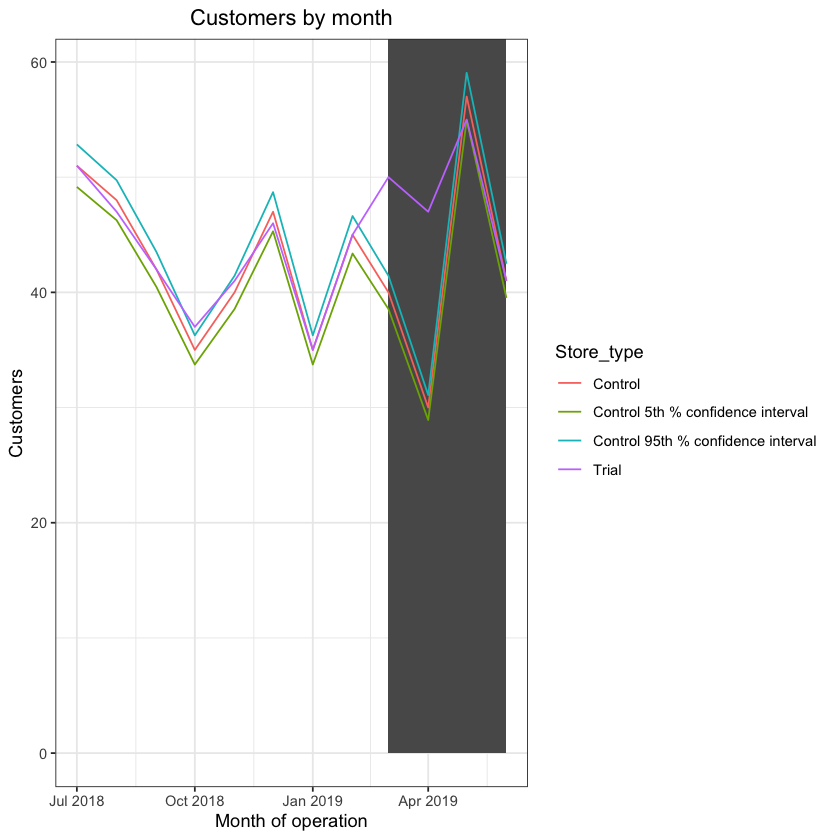

In [23]:
stdDev <- sd(percentageDiff[YEARMONTH < 201903 , percentageDiff])
degreesOfFreedom <- 7
#### Trial and control store number of customers
pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers)
                                      , by = c("YEARMONTH", "Store_type")
                                     ][Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",
                                ][, nCusts := nCusts * (1 + stdDev * 2)
                                ][, Store_type := "Control 95th % confidence interval"]

#### Control store 5th percentile
pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
                                ][, nCusts := nCusts * (1 - stdDev * 2)
                                ][, Store_type := "Control 5th % confidence interval"]
trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)
#### Plot on the graph
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
    geom_rect(data = trialAssessment[ YEARMONTH < 201907 & YEARMONTH > 201902 ,], 
              aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth),  
                  ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) +
    geom_line() +
    labs(x = "Month of operation", y = "Customers", title = "Customers by month")

The results show that the trial in store 77 can't tell whether it is significantly different to its control store in the trial period, as the trial store performance lies inside the 5% to 95% confidence interval of the control store in half of the four trial months.

## 4. Trail store 86<a class="anchor" id="4"></a>
### 4.1. Similarity calculation <a class='anchor' id='4.1'></a>
[Back to top](#table)

In [24]:
#### Re-create the dataset
measureOverTime <-  data[, .(totSales = sum(TOT_SALES),
                            nCustomers = uniqueN(LYLTY_CARD_NBR),
                            nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
                            nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID)),
                        ,by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]
#### Calculate correlations and magnitude for each potential control store
trial_store <- 86
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [25]:
#### combine score: 0.5 * correlation + 0.5 * magnitude
corr_weight <- 0.5
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))[
    , scoreNSales := corr_weight * corr_measure + (1-corr_weight) * mag_measure]
score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[
    , scoreNCust := corr_weight * corr_measure + (1-corr_weight) * mag_measure]

In [26]:
#### combine score: 0.5 * sales + 0.5 * nCustomers
score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))
score_Control[, finalControlScore := 0.5 * scoreNSales + 0.5 * scoreNCust]

### 4.2. Get the control store and vistual the trends <a class='anchor' id='4.2'></a>
[back on top](#table)

In [27]:
#### Select control stores based on the highest matching store
control_store <- score_Control[Store1 == trial_store, ][order(-finalControlScore)][2, Store2]
control_store  

[1] 155

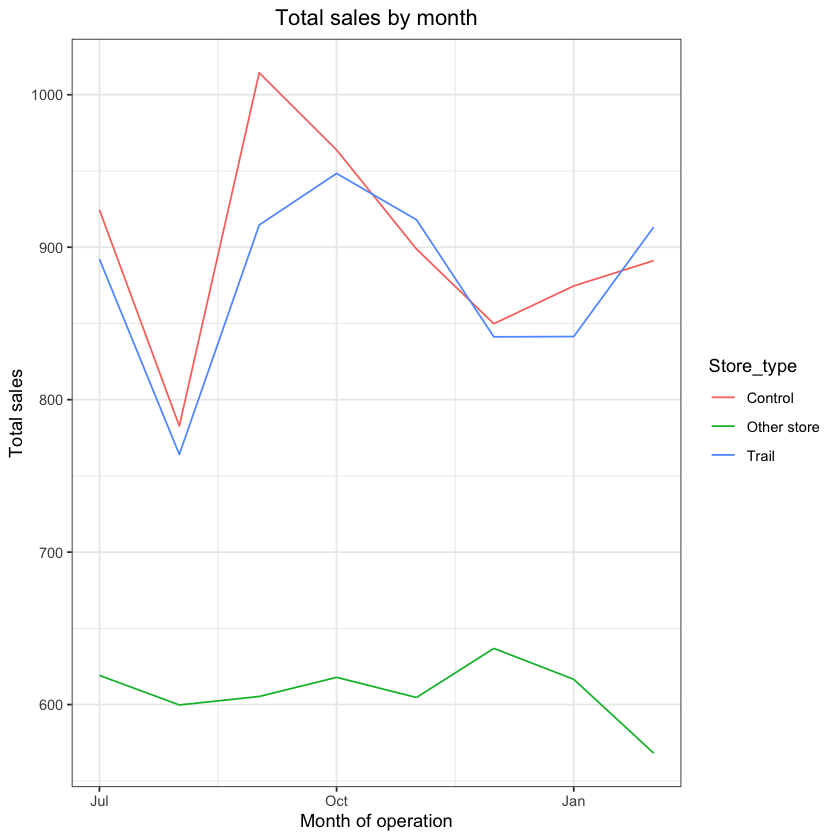

In [28]:
# visual checks on trends based on sales
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[
    , Store_type := ifelse(STORE_NBR == trial_store, "Trail",
                           ifelse(STORE_NBR == control_store, "Control", 
                                  "Other store"))][
    , totSales := mean(totSales), by = c("YEARMONTH", "Store_type")][
    , TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep="-"))][
    YEARMONTH < 201903, ]
ggplot(pastSales, aes(x = TransactionMonth, y = totSales, color=Store_type)) +
    geom_line() +
    labs(x="Month of operation", y = "Total sales", title = "Total sales by month")

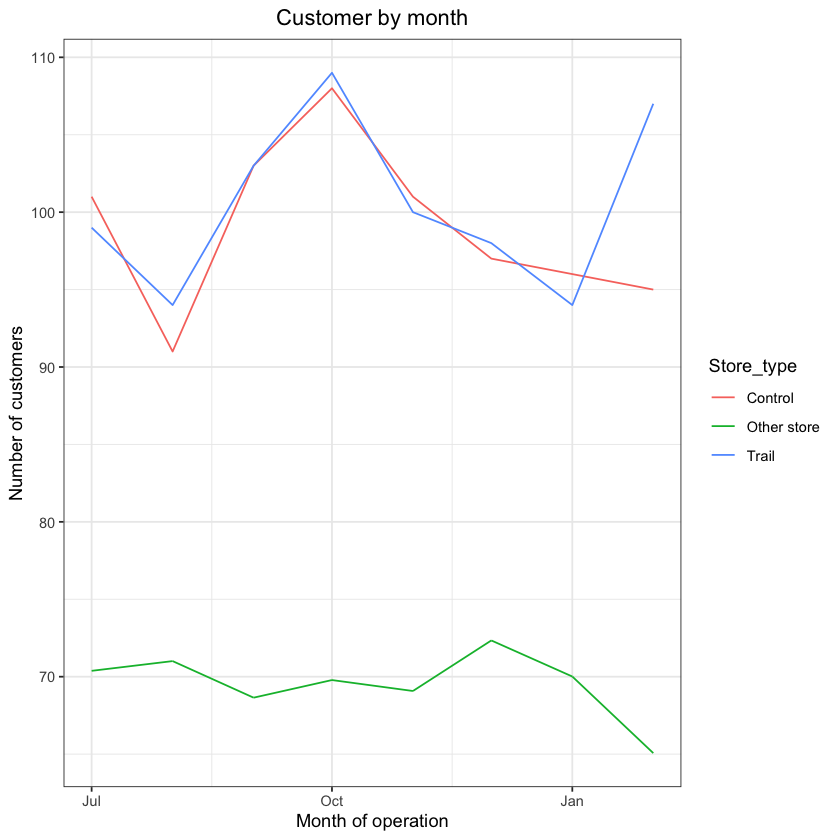

In [29]:
# visual checks on trends based on number of customers
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[
    , Store_type := ifelse(STORE_NBR == trial_store, "Trail", 
                         ifelse(STORE_NBR == control_store, "Control", 
                                "Other store"))][
    , numberCustomers := mean(nCustomers), by = c("Store_type", "YEARMONTH")][
    , TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1,sep = "-"))][
    YEARMONTH < 201903 , ]

ggplot(pastCustomers, aes(x = TransactionMonth, y = numberCustomers, color = Store_type)) +
    geom_line() +
    labs(x = "Month of operation", y = "Number of customers", title = "Customer by month")

### 4.3. Assessment of trial <a class='anchor' id='4.3'></a>
#### 4.3.1. Scale pre-trial control sales to pre-trial trail sales <a class='anchor' id='4.3.1'></a>
[back on top](#table)

In [30]:
#### Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales <- preTrialMeasures[
    STORE_NBR == trial_store & YEARMONTH < 201903, sum(totSales)]/preTrialMeasures[
    STORE_NBR == control_store & YEARMONTH < 201903, sum(totSales)]
scalingFactorForControlSales

[1] 0.9768261

In [31]:
#### Apply the scaling factor
measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][
    , controlSales := totSales * scalingFactorForControlSales]
head(scaledControlSales)

STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,Store_type,TransactionMonth,numberCustomers,controlSales
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>
155,201807,924.6,101,1.217822,2.032520,Control,2018-07-01,101,903.1734
155,201808,782.7,91,1.307692,1.924370,Control,2018-08-01,91,764.5618
155,201809,1014.4,103,1.398058,2.013889,Control,2018-09-01,103,990.8924
155,201810,963.8,108,1.259259,2.000000,Control,2018-10-01,108,941.4650
155,201811,898.8,101,1.316832,2.030075,Control,2018-11-01,101,877.9713
155,201812,849.8,97,1.237113,2.016667,Control,2018-12-01,97,830.1068


#### 4.3.2. Calculate percentage difference between scaled sales and true sales <a class='anchor' id='4.3.2'></a>
[back on top](#table)

In [32]:
percentageDiff <- merge(scaledControlSales[, c("YEARMONTH", "controlSales")],
                        measureOverTimeSales[STORE_NBR == trial_store, c("YEARMONTH", "totSales")],
                        by = "YEARMONTH")[
    , percentageDiff := abs(controlSales - totSales)/controlSales]
head(percentageDiff)

YEARMONTH,controlSales,totSales,percentageDiff
<dbl>,<dbl>,<dbl>,<dbl>
201807,903.1734,892.20,0.0121498062
201808,764.5618,764.05,0.0006693542
201809,990.8924,914.60,0.0769935921
201810,941.4650,948.40,0.0073662185
201811,877.9713,918.00,0.0455923017
201812,830.1068,841.20,0.0133635917


#### 4.3.3. Measure whether difference on sales is significant<a class='archor' id='4.3.3'></a>
[back on top](#table)

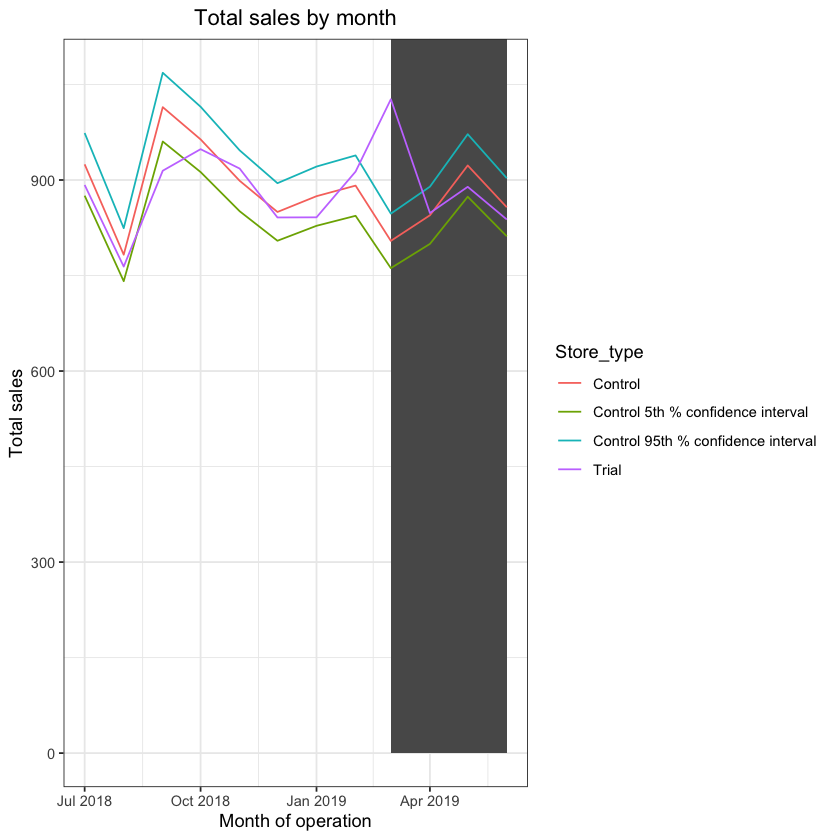

In [33]:
#### take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev <- sd(percentageDiff[YEARMONTH < 201903, percentageDiff])
degreesOfFreedom <- 7
#### Create a table with sales by store type and month.
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial", 
                                                         ifelse(STORE_NBR == control_store, "Control",
                                                                "Other store"))][
    , totSales := mean(totSales), by = c("Store_type","YEARMONTH")][
    , TransactionMonth := as.Date(paste(YEARMONTH%/%100, YEARMONTH%%100, 1, sep="-"), "%Y-%m-%d")][ 
    Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastSales_Controls95 <- pastSales[Store_type == "Control",
                                ][, totSales := totSales * (1 + stdDev * 2 )
                                ][, Store_type := "Control 95th % confidence interval"]
#### Control store 5th percentile
pastSales_Controls5 <- pastSales[Store_type == "Control",
                                ][, totSales := totSales * (1 - stdDev * 2)
                                ][, Store_type := "Control 5th % confidence interval"]
#### Create a combined table with columns from pastSales,pastSales_Controls95 and pastSales_Controls5
trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)
#### Plotting these in one graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
    geom_rect(data = trialAssessment[ YEARMONTH < 201907 & YEARMONTH > 201902 ,],
              aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth),  
                  ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) +
    geom_line() +
    labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

The results show that the trial in store 86 is not significantly different to its control store in the trial period, as the trial store performance lies inside the 5% to 95% confidence interval of the control store in three of the four trial months.

#### 4.3.4. Scale pre-trial control ncustomer to pre-trial trail ncustomer <a class='anchor' id='4.3.4'></a>
[back on top](#table)

In [34]:
#### Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust <- preTrialMeasures[
    STORE_NBR == trial_store &YEARMONTH < 201903, sum(nCustomers)]/preTrialMeasures[
    STORE_NBR == control_store & YEARMONTH < 201903, sum(nCustomers)]
scalingFactorForControlCust

[1] 1.015152

In [35]:
#### Apply the scaling factor
measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,][
    , controlCustomers := nCustomers * scalingFactorForControlCust][
    , Store_type := ifelse(STORE_NBR == trial_store, "Trail",
                           ifelse(STORE_NBR == control_store, "Control"
                                  , "Other store"))]
head(scaledControlCustomers)

STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,Store_type,TransactionMonth,numberCustomers,controlCustomers
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>
155,201807,924.6,101,1.217822,2.032520,Control,2018-07-01,101,102.53030
155,201808,782.7,91,1.307692,1.924370,Control,2018-08-01,91,92.37879
155,201809,1014.4,103,1.398058,2.013889,Control,2018-09-01,103,104.56061
155,201810,963.8,108,1.259259,2.000000,Control,2018-10-01,108,109.63636
155,201811,898.8,101,1.316832,2.030075,Control,2018-11-01,101,102.53030
155,201812,849.8,97,1.237113,2.016667,Control,2018-12-01,97,98.46970


#### 4.3.5. Calculate percentage difference between scaled ncustomers and true ncustomers <a class='anchor' id='4.3.5'></a>
[back on top](#table)

In [36]:
percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],
                        measureOverTimeCusts[STORE_NBR == trial_store, c("YEARMONTH", "nCustomers")])[
                          , percentageDiff := abs(controlCustomers - nCustomers) / controlCustomers]
head(percentageDiff)

YEARMONTH,controlCustomers,nCustomers,percentageDiff
<dbl>,<dbl>,<int>,<dbl>
201807,102.53030,99,0.034431801
201808,92.37879,94,0.017549615
201809,104.56061,103,0.014925373
201810,109.63636,109,0.005804312
201811,102.53030,100,0.024678587
201812,98.46970,98,0.004769965


#### 4.3.6. Measure whether difference on ncustomer is significant <a class= 'anchor' id='4.3.6'></a>
[back on top](#table)

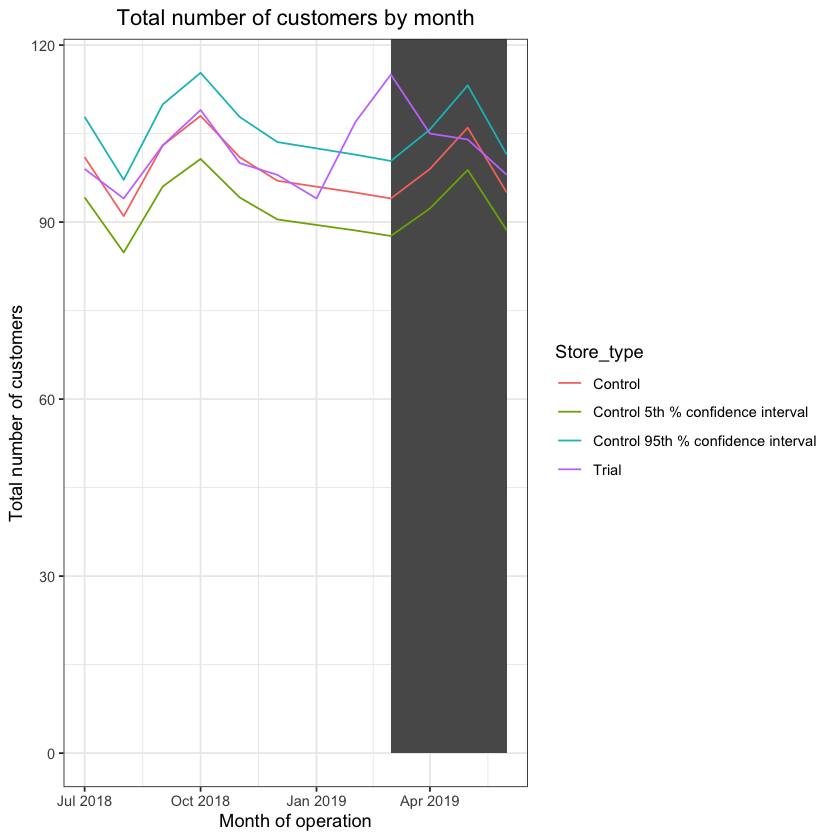

In [37]:
#### take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev <- sd(percentageDiff[YEARMONTH < 201903 , percentageDiff])
degreesOfFreedom <- 7
#### Create a table with sales by store type and month.
pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")][
    Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",
                                ][, nCusts := nCusts * (1 + stdDev * 2)
                                ][, Store_type := "Control 95th % confidence interval"]
#### Control store 5th percentile
pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
                                ][, nCusts := nCusts * (1 - stdDev * 2)
                                ][, Store_type := "Control 5th % confidence interval"]
trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
    geom_rect(data = trialAssessment[ YEARMONTH < 201907 & YEARMONTH > 201902 ,],
              aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth),  
                  ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) +
    geom_line() +
    labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

The results show that the trial in store 86 is not significantly different to its control store in the trial period, as the trial store performance lies inside the 5% to 95% confidence interval of the control store in three of the four trial months.

## 5. Trial store 88 <a class = 'anchor' id='5'></a>
### 5.1. Similarity calculation <a class='anchor' id='5.1'></a>
[back on top](#table)

In [38]:
#### Re-create dataset
measureOverTime <- data[, .(totSales = sum(TOT_SALES),
                            nCustomers = uniqueN(LYLTY_CARD_NBR),
                            nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
                            nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID),
                            avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)
                           )
                        , by = list(STORE_NBR, YEARMONTH) ][order(STORE_NBR, YEARMONTH),]

In [39]:
trial_store <- 88
#### Use the functions to calculate the correlation
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)
#### Use the functions to calculate the magnitude distance
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [40]:
corr_weight <- 0.5
#### Create a combined score composed of correlation and magnitude
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1","Store2"))[
    , scoreNSales := corr_weight * corr_measure + (1-corr_weight) * mag_measure]
score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1","Store2"))[
    , scoreNCust := corr_weight * corr_measure + (1-corr_weight) * mag_measure]

In [41]:
#### Combine scores across the drivers 
score_Control <- merge(score_nSales, score_nCustomers)
score_Control[, finalControlScore := 0.5 * scoreNSales + 0.5 * scoreNCust]

### 5.2. Get the control store and vistual the trends <a class='anchor' id='5.2'></a>
[back on top](#table)

In [42]:
control_store <- score_Control[Store1 == trial_store, ][order(-finalControlScore)][2, Store2]
control_store

[1] 237

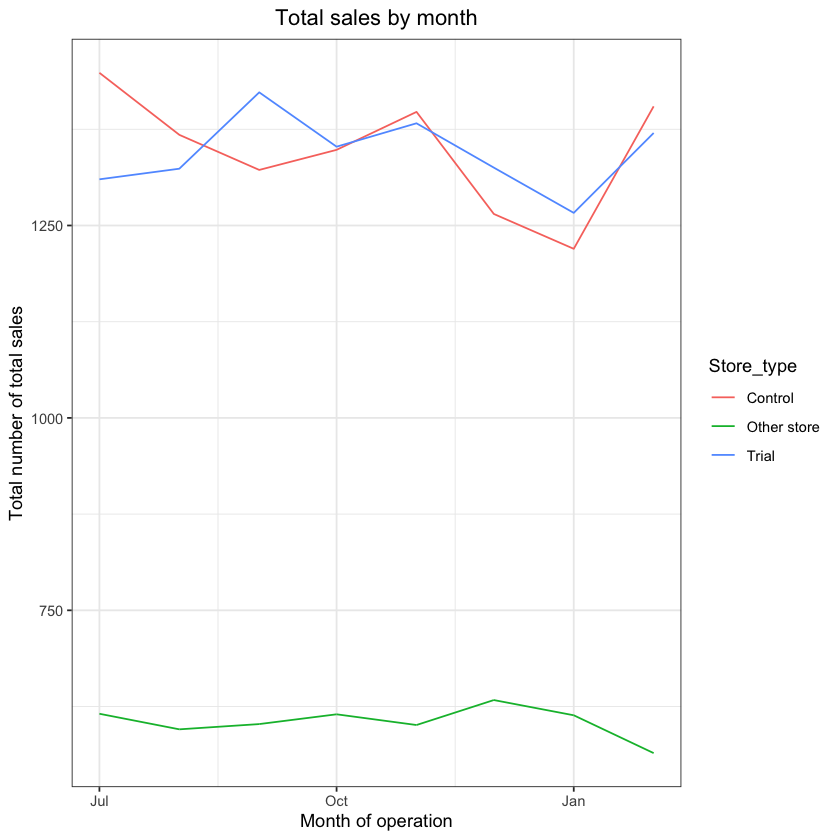

In [43]:
#### Visual checks on trends based on the drivers: sales
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[
    , Store_type:= ifelse(STORE_NBR == trial_store, "Trial",
                          ifelse(STORE_NBR == control_store, "Control", 
                                 "Other store"))][
    , totSales := mean(totSales), by = c("Store_type", "YEARMONTH")][
    , TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep="-"), "%Y-%m-%d")][
    YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color=Store_type)) +
    geom_line() +
    labs(x = "Month of operation", y = "Total number of total sales", title = "Total sales by month")

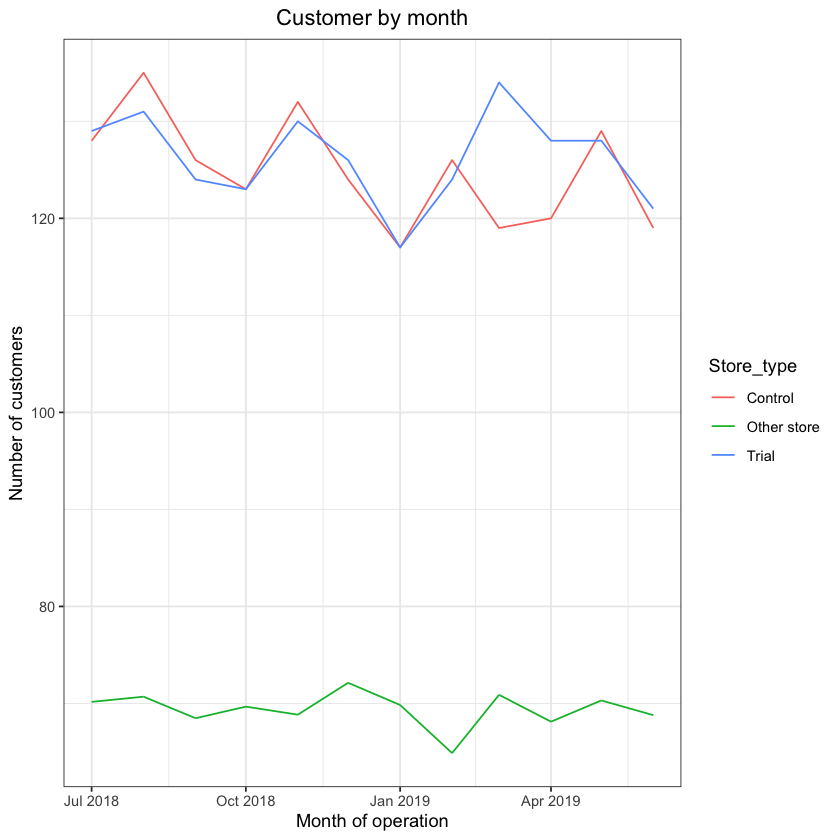

In [44]:
#### Visual checks on trends based on the drivers: nCustomers
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[
    , Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                           ifelse(STORE_NBR == control_store, "Control", "Other store"))][
    , numberCustomers := mean(nCustomers), by = c("Store_type", "YEARMONTH")][
    , TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep="-"), "%Y-%m-%d")]
ggplot(pastCustomers, aes(x=TransactionMonth, y=numberCustomers, color=Store_type)) +
    geom_line() +
labs(x = "Month of operation", y = "Number of customers", title = "Customer by month")

### 5.3. Assessment of trial <a class='anchor' id='5.3'></a>
#### 5.3.1. Scale pre-trial control sales to pre-trial trail sales<a class='anchor' id='5.3.1'></a>
[back on top](#table)

In [45]:
#### Scale pre-trial control store sales to match pre-trial trial store sales
scalingFactorForControlSales <- preTrialMeasures[
    STORE_NBR == trial_store & YEARMONTH < 201903,sum(totSales)]/preTrialMeasures[
    STORE_NBR == control_store & YEARMONTH < 201903, sum(totSales)]
scalingFactorForControlSales

[1] 0.9981436

In [46]:
#### Apply the scaling factor
measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][
    , controlSales := totSales * scalingFactorForControlSales]
head(scaledControlSales)

STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,TransactionMonth,numberCustomers,controlSales
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>
237,201807,1448.4,128,1.265625,2.000000,4.470370,Control,2018-07-01,128,1445.711
237,201808,1367.8,135,1.222222,1.896970,4.369968,Control,2018-08-01,135,1365.261
237,201809,1322.2,126,1.182540,2.006711,4.422074,Control,2018-09-01,126,1319.746
237,201810,1348.3,123,1.195122,2.034014,4.509365,Control,2018-10-01,123,1345.797
237,201811,1397.6,132,1.219697,1.987578,4.367500,Control,2018-11-01,132,1395.006
237,201812,1265.0,124,1.161290,2.006944,4.377163,Control,2018-12-01,124,1262.652


#### 5.3.2. Calculate percentage difference between scaled sales and true sales <a class='anchor' id='5.3.2'></a>
[back on top](#table)

In [47]:
#### Calculate the absolute percentage difference between scaled control sales and trial sales
percentageDiff <- merge(scaledControlSales[,c("YEARMONTH", "controlSales")],
                        measureOverTimeSales[STORE_NBR == trial_store, c("YEARMONTH", "totSales")],
                        by = "YEARMONTH")[
    , percentageDiff := abs(controlSales - totSales)/controlSales]
head(percentageDiff)

YEARMONTH,controlSales,totSales,percentageDiff
<dbl>,<dbl>,<dbl>,<dbl>
201807,1445.711,1310.0,0.093871618
201808,1365.261,1323.8,0.030368465
201809,1319.746,1423.0,0.078238168
201810,1345.797,1352.4,0.004906329
201811,1395.006,1382.8,0.008749469
201812,1262.652,1325.2,0.049537247


####  5.3.3. Measure whether difference on sales is significant <a class='anchor' id='5.3.3'></a>
[back on top](#table)

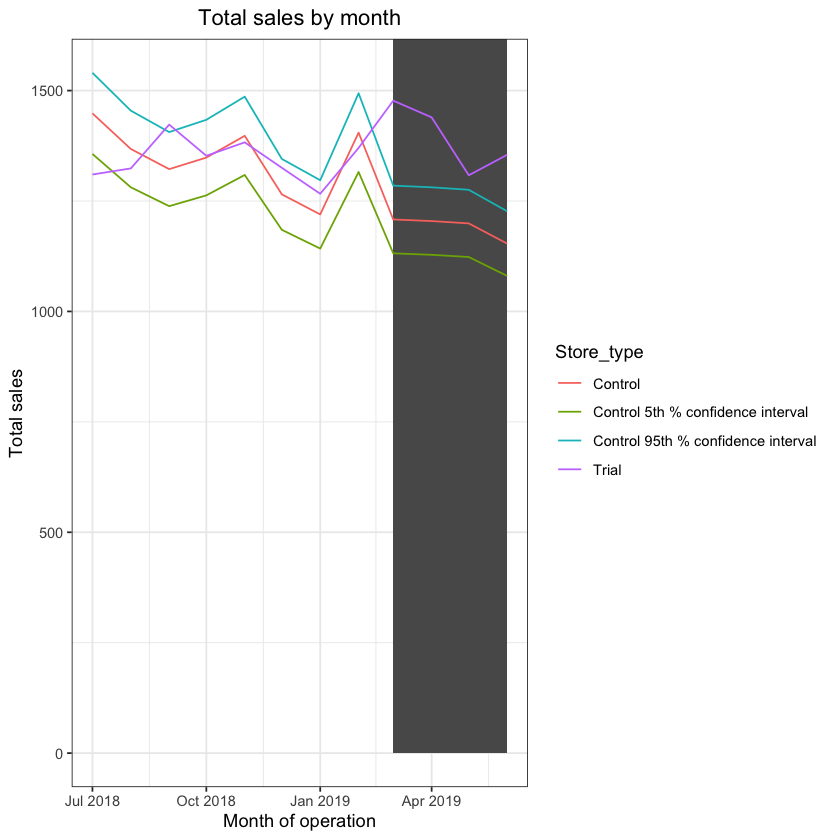

In [48]:
stdDev <- sd(percentageDiff[YEARMONTH < 201903, percentageDiff])
degreesOfFreedom <- 7
#### Trial and control store total sales
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[
    , Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                           ifelse(STORE_NBR == control_store, "Control", "Other store"))][
    , totSales := mean(totSales), by = c("Store_type","YEARMONTH")][
    , TransactionMonth := as.Date(paste(YEARMONTH%/%100, YEARMONTH%%100, 1, sep="-"), "%Y-%m-%d")][
    Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastSales_Controls95 <- pastSales[Store_type == "Control",
                                ][, totSales := totSales * (1 + stdDev * 2 )
                                ][, Store_type := "Control 95th % confidence interval"]
#### Control store 5th percentile
pastSales_Controls5 <- pastSales[Store_type == "Control",
                                ][, totSales := totSales * (1 - stdDev * 2)
                                ][, Store_type := "Control 5th % confidence interval"]
#### Combine the tables pastSales, pastSales_Controls95, pastSales_Controls5
trialAssessment <-rbind(pastSales, pastSales_Controls95, pastSales_Controls5)
#### Plot these in one graph
ggplot(trialAssessment, aes(x=TransactionMonth, y=totSales, color=Store_type)) +
    geom_rect(data = trialAssessment[ YEARMONTH < 201907 & YEARMONTH > 201902 ,],
              aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth),  
                  ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) +
    geom_line() +
    labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in all four trail months.

#### 5.3.4. Scale pre-trial control ncustomer to pre-trial trail ncustomer<a class='anchor' id='5.3.4'></a>
[back on top](#table)

In [49]:
scalingFactorForControlCust <- preTrialMeasures[
    STORE_NBR == trial_store & YEARMONTH < 201903, sum(nCustomers)]/preTrialMeasures[
    STORE_NBR == control_store & YEARMONTH < 201903, sum(nCustomers)]

In [50]:
#### Apply the scaling factor
measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,][
    , controlCustomers := nCustomers * scalingFactorForControlCust][
    , Store_type := ifelse(STORE_NBR == trial_store, "Trail", 
                           ifelse(STORE_NBR == control_store, "Control", "Other store"))]

#### 5.3.5. Calculate percentage difference between scaled nCustomers and true nCustomers<a class='anchor' id='5.3.5'></a>
[back on top](#table)

In [51]:
#### Calculate the absolute percentage difference between scaled control sales and trial sales
percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],
                        measureOverTimeCusts[Store_type == "Trial", c("YEARMONTH", "nCustomers")]
                        )[, percentageDiff := abs(controlCustomers - nCustomers)/controlCustomers]

#### 5.3.6. Measure whether difference on ncustomer is significant<a class='anchor' id='5.3.6'></a>
[back on top](#table)

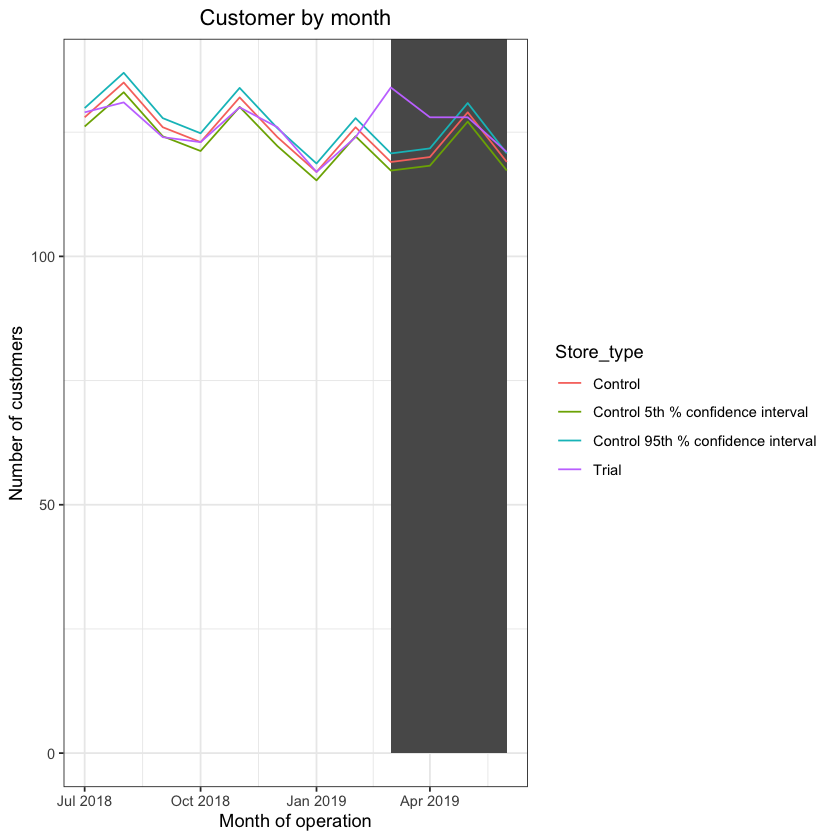

In [52]:
stdDev <- sd(percentageDiff[YEARMONTH < 201902, percentageDiff])
degreesOfFreedom <- 7
#### Trial and control store number of customers
pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")][
    Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",][
  , nCusts := nCusts * (1 + 2 * stdDev)][
  , Store_type := "Control 95th % confidence interval"]
#### Control store 5th percentile
pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",][
  , nCusts := nCusts * (1 - 2 * stdDev)][
  , Store_type := "Control 5th % confidence interval"]
#### Combine the tables pastSales, pastSales_Controls95, pastSales_Controls5
trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(x=TransactionMonth, y=nCusts, color=Store_type)) +
    geom_rect(data=trialAssessment[ YEARMONTH>201902 & YEARMONTH<201907, ], 
              aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth),
                  ymin = 0, ymax = Inf, color = NULL), show.legend = FALSE) +
    geom_line() +
    labs(x = "Month of operation", y = "Number of customers", title = "Customer by month")

Total number of customers in the trial period for the trial store is significantly higher than the control store for three out of four months, which indicates a positive trial effect.

## 6. Conclusion <a class='anchor' id='6'></a>
[back on top](#table)

- Control store for Trail store 77, 86 and 88 are separately 233, 155, 237
- For trail store 77, the sales is significantly different during the trail period while number of customers isn't significantly different from control store.
- For trail store 86, both of the sales and number of customers are not significantly different during the trail period.
- For trail store 88, both of the sales and number of customers are significantly different during the trail period.